# Object reconstruction (with probe known) with the gaussian noise model 

In [1]:
import ptychoSampling.farfield.run_methods.utils as utils  
import ptychoSampling.farfield.run_methods.params as params
import dataclasses as dt
import tensorflow as tf
import numpy as np
from ptychoSampling.logger import logger
import matplotlib.pyplot as plt

logger.setLevel("WARNING")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# If set to true, this will reload the simulation (with the custom parameters) saved by simulation.ipynb
# If false, will load new simulation with some default parameters.

reload_simulation = True
base_path = './'

sim_items = utils.getSimulationAndGuesses(default_path_str=base_path, reload_simulation=reload_simulation)

Loaded successfully


In [4]:
sim_items.keys()

dict_keys(['obj', 'probe', 'scan_grid', 'intensities', 'default_obj_guess', 'default_probe_guess'])

0.999973583521523 6.50420582283262e-05


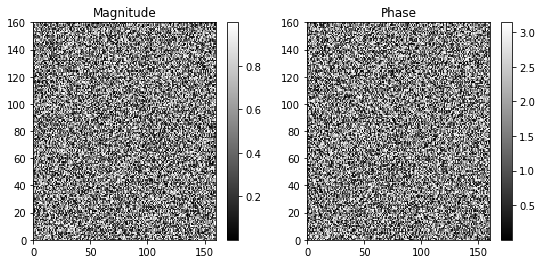

In [5]:
# Default obj guess is a random complex array

print(np.abs(sim_items["default_obj_guess"].array).max(), np.abs(sim_items["default_obj_guess"].array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(sim_items["default_obj_guess"].array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


In [6]:
loss_type = 'gaussian'
background_level = sim_items['intensities'].max() * 1e-8

### Preconditioned conjugate gradient`

In [7]:
from ptychoSampling.farfield.run_methods.recons_methods import CGReconstructionT

In [8]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = CGReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond=True,
                           background_level=background_level,
                           obj_abs_proj=False)

Setting background_level to 8.7e-07...


In [9]:
recons.run(200, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_ls_iters  obj_alpha  obj_error   obj_nlse   r_factor
20         20    1.52e+05            28    0.00382      0.615      0.417      0.475
40         40   1.34e+05         60    0.00765      0.313     0.0986      0.421
60         60   1.31e+05         93    0.00765      0.166     0.0277      0.413
80         80   1.31e+05        127    0.00765      0.134     0.0184      0.412
100        100   1.31e+05        158    0.00765      0.135     0.0186      0.412
120        120   1.31e+05        197    0.00382      0.135     0.0186      0.412
140        140   1.31e+05        235    0.00191      0.136     0.0187      0.412
160        160   1.31e+05        269    0.00382      0.136     0.0187      0.412
180        180   1.31e+05        306   0.000239      0.136     0.0187      0.412
200        200   1.31e+05        338    0.00382      0.136     0.0187      0.412


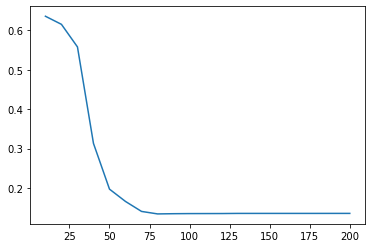

In [10]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0662012 0.050260037


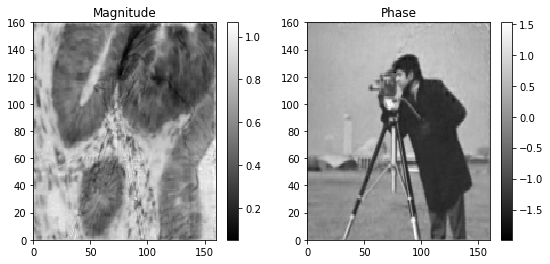

In [11]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### Levenberg-Marquardt

In [12]:
from ptychoSampling.farfield.run_methods.recons_methods import LMAReconstructionT

In [13]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = LMAReconstructionT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           apply_precond_and_scaling=True,
                           background_level=background_level,
                           obj_abs_proj=False)

Loss init args None
Setting background_level to 8.7e-07...
obj_opt_init_extra_kwargs {}
Extra initial parameters: {'diag_mu_scaling_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'diag_precond_t': <tf.Tensor 'concat:0' shape=(51200,) dtype=float32>, 'grad_norm_regularization_power': 0, 'mu': 1.0, 'name': 'obj_opt', 'min_cg_tol': 0.1, 'stochastic_diag_estimator_type': None, 'stochastic_diag_estimator_iters': 1, 'assert_tolerances': False}


In [14]:
recons.run(200, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_cg_iters  obj_ls_iters  obj_proj_iters     obj_mu  obj_error   obj_nlse   r_factor
20         20    1.31e+05           134             0               0       0.25      0.137      0.019      0.413
40         40   1.31e+05        211          0          0     0.0156      0.136     0.0188      0.412
60         60   1.31e+05        270          0          0       0.25      0.136     0.0188      0.412
80         80   1.31e+05        301          0          0      1e+10      0.136     0.0188      0.412
100        100   1.31e+05        321          0          0      1e+10      0.136     0.0188      0.412
120        120   1.31e+05        341          0          0      1e+10      0.136     0.0188      0.412
140        140   1.31e+05        361          0          0      1e+10      0.136     0.0188      0.412
160        160   1.31e+05        381          0          0      1e+10      0.136     0.0188      0.412
180        180   1.31e+05        401          0       

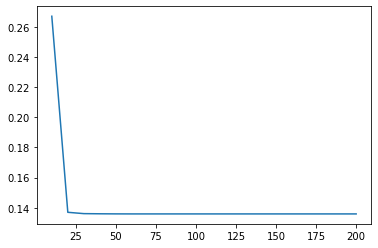

In [15]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0668305 0.049972355


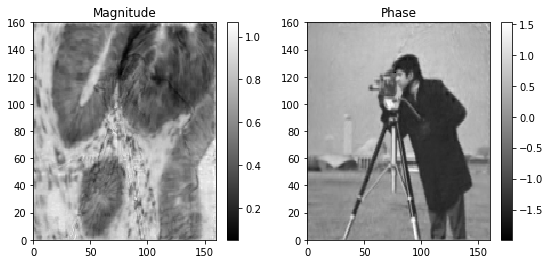

In [16]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### Nesterov's momentum

In [17]:
from ptychoSampling.farfield.run_methods.recons_methods import AcceleratedWirtingerFlowT

In [18]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = AcceleratedWirtingerFlowT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           background_level=background_level,
                           obj_abs_proj=False,
                           use_momentum=True)

Setting background_level to 8.7e-07...


In [19]:
recons.run(200, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_error   obj_nlse   r_factor
20         20    1.52e+05      0.636      0.447       0.44
40         40   1.36e+05      0.475      0.235      0.419
60         60   1.31e+05      0.167     0.0279      0.412
80         80   1.31e+05      0.165     0.0275      0.413
100        100   1.31e+05      0.149     0.0225      0.412
120        120   1.31e+05      0.135     0.0185      0.412
140        140   1.31e+05       0.15     0.0226      0.412
160        160   1.31e+05      0.148     0.0222      0.412
180        180   1.31e+05      0.135     0.0186      0.412
200        200   1.31e+05      0.134     0.0183      0.412


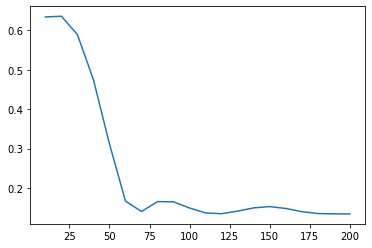

In [20]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0618206 0.051334202


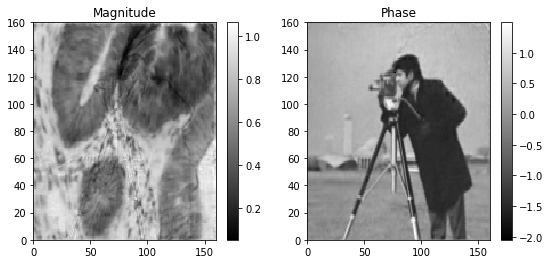

In [21]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()


### Steepest descent with the Lipschitz constant as the step size

In [22]:
from ptychoSampling.farfield.run_methods.recons_methods import AcceleratedWirtingerFlowT

In [23]:
# Supplying the true probe for the probe guess
# the obj_abs_proj=False parameter ensures that we don't use any object constraints

recons = AcceleratedWirtingerFlowT(obj=sim_items['default_obj_guess'],
                           probe=sim_items['probe'],
                           loss_type= loss_type,
                           grid= sim_items["scan_grid"],
                           intensities= sim_items["intensities"],
                           obj_array_true= sim_items["obj"].array,
                           reconstruct_probe=False,
                           background_level=background_level,
                           obj_abs_proj=False,
                           use_momentum=False)

Setting background_level to 8.7e-07...


In [24]:
recons.run(500, debug_output_epoch_frequency=20)

        epoch  train_loss  obj_error   obj_nlse   r_factor
20         20    1.76e+05      0.626      0.425      0.466
40         40   1.63e+05      0.624      0.425      0.451
60         60   1.56e+05       0.62       0.42      0.444
80         80   1.51e+05      0.613      0.409      0.439
100        100   1.48e+05      0.602      0.393      0.435
120        120   1.45e+05      0.588      0.373      0.432
140        140   1.43e+05      0.572      0.351      0.429
160        160   1.42e+05      0.555      0.328      0.427
180        180    1.4e+05      0.536      0.304      0.425
200        200   1.39e+05      0.516      0.281      0.424
220        220   1.38e+05      0.496      0.258      0.422
240        240   1.37e+05      0.476      0.236      0.421
260        260   1.37e+05      0.456      0.215       0.42
280        280   1.36e+05      0.436      0.196      0.419
300        300   1.35e+05      0.417      0.178      0.418
320        320   1.35e+05      0.398      0.162      0.417


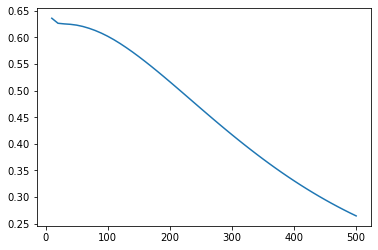

In [25]:
plt.plot(recons.datalog.dataframe.obj_error.dropna())

1.0959679 0.046692


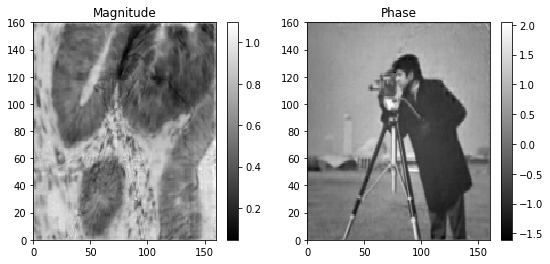

In [26]:
# Reconstructed object

print(np.abs(recons.obj.array).max(), np.abs(recons.obj.array).min())

# Showing juust the object guess
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons.obj.array), cmap='gray')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(recons.obj.array), cmap='gray')
plt.title('Phase')
plt.colorbar()
plt.show()
